## 加载相关包

In [78]:
import pandas as pd 
import numpy as np
import seaborn as sns
import jieba
import math
from tqdm import tqdm
from gensim import corpora
from gensim.models import Word2Vec, TfidfModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier as XGBC
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from warnings import filterwarnings
from tkinter import _flatten
filterwarnings('ignore')

## 加载数据

In [2]:
with open('train_dataset_v2.tsv', 'r', encoding='utf-8') as handler:
    lines = handler.read().split('\n')[1:-1]

    data = list()
    for line in tqdm(lines):
        # 处理异常数据         
        sp = line.split('\t')
        if len(sp) != 4:
            print("ERROR:", sp)
            continue
        data.append(sp)

train = pd.DataFrame(data)
train.columns = ['id', 'content', 'character', 'emotions']

test = pd.read_csv('test_dataset.tsv', sep='\t')  # 测试数据
submit = pd.read_csv('submit_example.tsv', sep='\t')  # 提交样例
train = train[train['emotions'] != '']

100%|██████████| 42790/42790 [00:00<00:00, 541612.90it/s]


In [3]:
with open('D:\Code\Jupyter_code\文本挖掘项目\stopword.txt', 'r', encoding='utf-8') as fp:
    stopword = set()
    word = fp.readlines()
    for w in word:
        stopword.add(w.replace('\n', ''))

In [4]:
train.shape, test.shape, submit.shape 

((36782, 4), (21376, 3), (21376, 2))

In [5]:
train.head()

,id,content,character,emotions
0,1171_0001_A_1,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,o2,"0,0,0,0,0,0"
1,1171_0001_A_2,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,c1,"0,0,0,0,0,0"
2,1171_0001_A_3,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,o2,"0,0,0,0,0,0"
3,1171_0001_A_4,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,c1,"0,0,0,0,0,0"
4,1171_0001_A_5,o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...,o2,"0,0,0,0,0,0"


In [6]:
test.head()

,id,content,character
0,34170_0002_A_12,穿着背心的b1醒来，看看手机，三点了。,b1
1,34170_0002_A_14,b1走出卧室。,b1
2,34170_0003_A_16,b1拿着手机，点开计时功能。,b1
3,34170_0003_A_17,b1站在淋浴头下面，水从b1的头和脸上冲刷而过。,b1
4,34170_0003_A_18,b1摈着呼吸。,b1


## 数据预处理处理

### 文本拼接

In [7]:
train['text'] = train[ 'content'].astype(str)  +'角色: ' + train['character'].astype(str)
test['text'] = test['content'].astype(str) + ' 角色: ' + test['character'].astype(str)

### 文本分词

In [9]:
content = pd.concat([train['text'], test['text']]).reset_index(drop=True)

In [10]:
content_cut = content.apply(lambda text:[w for w in jieba.lcut(text) if w not in stopword])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hx\AppData\Local\Temp\jieba.cache
Loading model cost 0.924 seconds.
Prefix dict has been built successfully.


## bert构建句向量

In [12]:
from bert_serving.client import BertClient
bc = BertClient()

In [20]:
bert_X = bc.encode(train['content'].tolist())

In [27]:
y = train['emotions']
y = np.array(list(map(lambda ls:list(map(int, ls)), list(map(lambda string: string.split(','), y.values)))))

x_train, x_test, y_train, y_test = train_test_split(bert_X, y, test_size=0.2, random_state=2021)
x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])

In [106]:
bigru = Sequential()
bigru.add(layers.Bidirectional(layers.GRU(128), input_shape=(None, 768)))
bigru.add(layers.Dropout(0.5))
bigru.add(layers.Dense(6))
bigru.compile(optimizer=RMSprop(), loss='mse')

In [ ]:
# es = EarlyStopping(monitor='val_loss', patience=1)
History = bigru.fit(bert_X.reshape(bert_X.shape[0],1,bert_X.shape[1]), y, batch_size=128, epochs=5,validation_split=0.2)

Train on 29425 samples, validate on 7357 samples
Epoch 1/5
19712/29425 [===================>..........] - ETA: 6s - loss: 0.2738

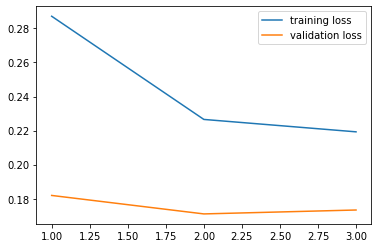

In [98]:
import matplotlib.pyplot as plt
epochs = range(1, len(History.history['loss'])+1)
plt.plot(epochs, History.history['loss'], label='training loss')
plt.plot(epochs, History.history['val_loss'], label='validation loss')
plt.legend()

In [99]:
test_pred = bigru.predict(x_test.reshape(x_test.shape[0],1,x_test.shape[1]))
rmse = np.sqrt(((test_pred - y_test) ** 2).sum()/(6*y_test.shape[0]))
score = 1 / (1 + rmse)
score

0.6917795774969923

In [47]:
gru_pred = bc.encode(test['content'].tolist())

In [51]:
gru_predict = bigru.predict(gru_pred.reshape(gru_pred.shape[0], 1, gru_pred.shape[1]))

In [52]:
gru_predict = list(map(lambda ls:','.join(list(map(str, ls))), list(gru_predict)))

In [53]:
sub = submit.copy()
sub['id'] = test['id']
sub['emotion'] = gru_predict

In [54]:
sub.to_csv(f'bert_gru_pred.tsv', sep='\t', index=False)

### word2vec构建词向量

In [12]:
def word2vec_model():
    model = Word2Vec(content_cut.to_list(), vector_size=200, window=5, min_count=1, seed=1, workers=4)
    model.save("word2vec.model")
word2vec_model()

In [13]:
model = Word2Vec.load("word2vec.model")
model.train(content_cut.to_list(), total_examples=model.corpus_count, epochs=10)
wv = model.wv

In [14]:
def get_text_vec():
    text_vec = np.zeros((content.shape[0], 200))
    for ind, text in enumerate(content):
        wlen = len(text)
        vec = np.zeros((1, 200))
        for w in text:
            try:
                vec += wv[w]
            except:
                pass
        text_vec[ind] = vec/wlen
    word2vec = pd.DataFrame(data=text_vec)
    word2vec.to_csv('word2vec.csv', index=False)
get_text_vec()

In [15]:
text_vec = pd.read_csv('word2vec.csv')

In [16]:
text_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.287983,0.239072,0.041370,0.008274,0.150682,0.064476,0.145689,0.116890,-0.404228,0.122925,...,-0.301505,0.086171,0.171144,-0.165600,0.274524,-0.014853,0.127183,0.178372,-0.064102,-0.007949
1,-0.296018,0.241943,0.046356,0.001387,0.145324,0.070459,0.146692,0.115230,-0.397731,0.126358,...,-0.303598,0.089348,0.182960,-0.165907,0.278168,-0.011777,0.126024,0.184988,-0.071368,-0.006784
2,-0.105292,0.095393,0.263808,-0.222095,0.439335,0.084933,-0.075143,0.253390,-0.152075,0.079878,...,-0.372476,-0.035087,0.089030,-0.257707,0.107796,-0.122243,0.400839,-0.388399,-0.388311,0.283492
3,-0.116400,0.099361,0.270700,-0.231615,0.431929,0.093204,-0.073756,0.251096,-0.143094,0.084625,...,-0.375370,-0.030695,0.105363,-0.258130,0.112833,-0.117992,0.399236,-0.379254,-0.398354,0.285102
4,-0.097889,-0.130441,0.089530,-0.167821,0.251095,0.240528,0.071192,0.048989,0.175803,0.048601,...,-0.282128,-0.033234,0.087585,-0.481931,0.033087,0.396729,0.395582,-0.136954,0.217406,-0.079245


In [17]:
text_vec.shape

(58158, 200)

## 6 模型构建与训练

### 6.1 划分训练集与测试集

In [27]:
X = text_vec.values[:train.shape[0]]
y = train['emotions']
y = np.array(list(map(lambda ls:list(map(int, ls)), list(map(lambda string: string.split(','), y.values)))))

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])

### 双向LSTM 

In [29]:
bilstm = Sequential()
bilstm.add(layers.Bidirectional(layers.LSTM(64)))
bilstm.add(layers.Dropout(0.5))
bilstm.add(layers.Dense(6))
bilstm.compile(optimizer='rmsprop', loss='mse', metrics=['mean_squared_error'])

NameError: name 'Sequential' is not defined

In [254]:
History = bilstm.fit(arg_x_train[:,np.newaxis],arg_y_train, batch_size=256, epochs=20, validation_data=(x_test[:,np.newaxis], y_test))

Train on 58849 samples, validate on 7357 samples
Epoch 1/20
58849/58849 [==============================] - 15s 253us/step - loss: 0.1792 - mean_squared_error: 0.1792 - val_loss: 0.2269 - val_mean_squared_error: 0.2269
Epoch 2/20
58849/58849 [==============================] - 7s 118us/step - loss: 0.1755 - mean_squared_error: 0.1755 - val_loss: 0.2256 - val_mean_squared_error: 0.2256
Epoch 3/20
58849/58849 [==============================] - 7s 116us/step - loss: 0.1744 - mean_squared_error: 0.1744 - val_loss: 0.2248 - val_mean_squared_error: 0.2248
Epoch 4/20
58849/58849 [==============================] - 7s 118us/step - loss: 0.1736 - mean_squared_error: 0.1736 - val_loss: 0.2241 - val_mean_squared_error: 0.2241
Epoch 5/20
58849/58849 [==============================] - 7s 116us/step - loss: 0.1729 - mean_squared_error: 0.1729 - val_loss: 0.2239 - val_mean_squared_error: 0.2239
Epoch 6/20
58849/58849 [==============================] - 7s 119us/step - loss: 0.1724 - mean_squared_error: 0

In [255]:
test_pred = bilstm.predict(x_test.reshape(x_test.shape[0],1,200))

In [256]:
rmse = np.sqrt(((test_pred - y_test) ** 2).sum()/(6*y_test.shape[0]))
score = 1 / (1 + rmse)
score

0.6809010893545276

### mixup数据增强

In [333]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])

In [210]:
arg_x_train = x_train[0]
for n in range(x_train.shape[0]):
    if n < x_train.shape[0]-1:
        arg_x_train = np.vstack([arg_x_train, (x_train[n]+x_train[n+1])/2])
        arg_x_train = np.vstack([arg_x_train, x_train[n+1]])

In [263]:
arg_y_train = y_train[0]
for n in range(y_train.shape[0]):
    if n < y_train.shape[0]-1:
        arg_y_train = np.vstack([arg_y_train, (y_train[n]+y_train[n+1])/2])
        arg_y_train = np.vstack([arg_y_train, y_train[n+1]])

### 另一种增强方式

认为前一段文本情感受后一段影响，将一段文本向量Li表示成 0.8*Li+0.2*Li+1

In [277]:
a_text_vec = X.copy()
a_y = y.copy()
for n in range(X.shape[0]):
    if n<X.shape[0]-1:
        a_text_vec[n] = 0.8*a_text_vec[n]+0.2*a_text_vec[n+1]
        a_y[n] = 0.8*a_y[n]+0.2*a_y[n+1]

In [319]:
x_train, x_test, y_train, y_test = train_test_split(a_text_vec, a_y, test_size=0.2, random_state=2021)

x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])

In [289]:
a_text_vec.shape

(36782, 200)

In [288]:
x_train.shape

(29425, 1, 200)

In [297]:
a_y.shape

(36782, 6)

### 双向gru

In [314]:
bigru = Sequential()
bigru.add(layers.Bidirectional(layers.GRU(128), input_shape=(None, 200)))
bigru.add(layers.Dropout(0.5))
bigru.add(layers.Dense(6))
bigru.compile(optimizer=RMSprop(), loss='mse')

In [315]:
History = bigru.fit(x_train, y_train, batch_size=256, epochs=20,validation_split=0.2)

Train on 23540 samples, validate on 5885 samples
Epoch 1/20
23540/23540 [==============================] - 16s 700us/step - loss: 0.1322 - val_loss: 0.1230
Epoch 2/20
23540/23540 [==============================] - 7s 288us/step - loss: 0.1249 - val_loss: 0.1212
Epoch 3/20
23540/23540 [==============================] - 7s 281us/step - loss: 0.1233 - val_loss: 0.1212
Epoch 4/20
23540/23540 [==============================] - 7s 300us/step - loss: 0.1227 - val_loss: 0.1207
Epoch 5/20
23540/23540 [==============================] - 7s 314us/step - loss: 0.1221 - val_loss: 0.1199
Epoch 6/20
23540/23540 [==============================] - 7s 304us/step - loss: 0.1217 - val_loss: 0.1200
Epoch 7/20
23540/23540 [==============================] - 7s 318us/step - loss: 0.1211 - val_loss: 0.1195
Epoch 8/20
23540/23540 [==============================] - 7s 303us/step - loss: 0.1212 - val_loss: 0.1198
Epoch 9/20
23540/23540 [==============================] - 7s 309us/step - loss: 0.1207 - val_loss: 0.1

In [316]:
test_pred = bigru.predict(x_test.reshape(x_test.shape[0],1,200))

In [320]:
rmse = np.sqrt(((test_pred - y_test) ** 2).sum()/(6*y_test.shape[0]))
score = 1 / (1 + rmse)
score

0.7448580034049752

In [332]:
res = test_pred.copy()
for n in range(res.shape[0]-2, -1, -1):
    res[n] = (res[n]-0.2*res[n+1])/0.8

In [334]:
rmse = np.sqrt(((res - y_test) ** 2).sum()/(6*y_test.shape[0]))
score = 1 / (1 + rmse)
score

0.6776760163356741

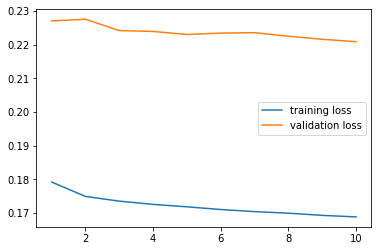

In [246]:
import matplotlib.pyplot as plt
epochs = range(1, len(History.history['loss'])+1)
plt.plot(epochs, History.history['loss'], label='training loss')
plt.plot(epochs, History.history['val_loss'], label='validation loss')
plt.legend()

In [257]:
gru_pred = text_vec.values[train.shape[0]:].reshape(test.shape[0],1,200)

In [258]:
gru_predict = bigru.predict(gru_pred)

In [259]:
gru_predict = list(map(lambda ls:','.join(list(map(str, ls))), list(gru_predict)))

In [260]:
sub = submit.copy()
sub['id'] = test['id']
sub['emotion'] = gru_predict

In [261]:
sub.to_csv(f'argment_gru_pred.tsv', sep='\t', index=False)

## bert的encoder

### config（保存一些超参数）

In [31]:
import torch
import torch.nn as nn
import numpy as np
import math


class Config(object):
    def __init__(self):
        self.vocab_size = 6

        self.d_model = 20
        self.n_heads = 2

        assert self.d_model % self.n_heads == 0
        dim_k  = self.d_model % self.n_heads
        dim_v = self.d_model % self.n_heads

        self.padding_size = 30
        self.UNK = 5
        self.PAD = 4

        self.N = 6
        self.p = 0.1

config = Config()

### embedding

In [39]:
train.head()

,id,content,character,emotions,text
0,1171_0001_A_1,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,o2,"0,0,0,0,0,0",天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o2
1,1171_0001_A_2,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,c1,"0,0,0,0,0,0",天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: c1
2,1171_0001_A_3,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,o2,"0,0,0,0,0,0",o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: o2
3,1171_0001_A_4,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,c1,"0,0,0,0,0,0",o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: c1
4,1171_0001_A_5,o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...,o2,"0,0,0,0,0,0",o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...


In [32]:
class Embedding(nn.Module):
    def __init__(self,vocab_size):
        super(Embedding, self).__init__()
        # 一个普通的 embedding层，我们可以通过设置padding_idx=config.PAD 来实现论文中的 padding_mask
        self.embedding = nn.Embedding(vocab_size,config.d_model,padding_idx=config.PAD)


    def forward(self,x):
        # 根据每个句子的长度，进行padding，短补长截
        for i in range(len(x)):
            if len(x[i]) < config.padding_size:
                x[i].extend([config.UNK] * (config.padding_size - len(x[i]))) # 注意 UNK是你词表中用来表示oov的token索引，这里进行了简化，直接假设为6
            else:
                x[i] = x[i][:config.padding_size]
        x = self.embedding(torch.tensor(x)) # batch_size * seq_len * d_model
        return x

In [33]:
class Positional_Encoding(nn.Module):

    def __init__(self,d_model):
        super(Positional_Encoding,self).__init__()
        self.d_model = d_model


    def forward(self,seq_len,embedding_dim):
        positional_encoding = np.zeros((seq_len,embedding_dim))
        for pos in range(positional_encoding.shape[0]):
            for i in range(positional_encoding.shape[1]):
                positional_encoding[pos][i] = math.sin(pos/(10000**(2*i/self.d_model))) if i % 2 == 0 else math.cos(pos/(10000**(2*i/self.d_model)))
        return torch.from_numpy(positional_encoding)

###  Encoder（Muti_head_Attention）

In [34]:
class Mutihead_Attention(nn.Module):
    def __init__(self,d_model,dim_k,dim_v,n_heads):
        super(Mutihead_Attention, self).__init__()
        self.dim_v = dim_v
        self.dim_k = dim_k
        self.n_heads = n_heads

        self.q = nn.Linear(d_model,dim_k)
        self.k = nn.Linear(d_model,dim_k)
        self.v = nn.Linear(d_model,dim_v)

        self.o = nn.Linear(dim_v,d_model)
        self.norm_fact = 1 / math.sqrt(d_model)

    def generate_mask(self,dim):
        # 此处是 sequence mask ，防止 decoder窥视后面时间步的信息。
        # padding mask 在数据输入模型之前完成。
        matirx = np.ones((dim,dim))
        mask = torch.Tensor(np.tril(matirx))

        return mask==1

    def forward(self,x,y,requires_mask=False):
        assert self.dim_k % self.n_heads == 0 and self.dim_v % self.n_heads == 0
        # size of x : [batch_size * seq_len * batch_size]
        # 对 x 进行自注意力
        Q = self.q(x).reshape(-1,x.shape[0],x.shape[1],self.dim_k // self.n_heads) # n_heads * batch_size * seq_len * dim_k
        K = self.k(x).reshape(-1,x.shape[0],x.shape[1],self.dim_k // self.n_heads) # n_heads * batch_size * seq_len * dim_k
        V = self.v(y).reshape(-1,y.shape[0],y.shape[1],self.dim_v // self.n_heads) # n_heads * batch_size * seq_len * dim_v
        # print("Attention V shape : {}".format(V.shape))
        attention_score = torch.matmul(Q,K.permute(0,1,3,2)) * self.norm_fact
        if requires_mask:
            mask = self.generate_mask(x.shape[1])
            attention_score.masked_fill(mask,value=float("-inf")) # 注意这里的小Trick，不需要将Q,K,V 分别MASK,只MASKSoftmax之前的结果就好了
        output = torch.matmul(attention_score,V).reshape(y.shape[0],y.shape[1],-1)
        # print("Attention output shape : {}".format(output.shape))

        output = self.o(output)
        return output

In [35]:
class Feed_Forward(nn.Module):
    def __init__(self,input_dim,hidden_dim=2048):
        super(Feed_Forward, self).__init__()
        self.L1 = nn.Linear(input_dim,hidden_dim)
        self.L2 = nn.Linear(hidden_dim,input_dim)

    def forward(self,x):
        output = nn.ReLU()(self.L1(x))
        output = self.L2(output)
        return output

In [36]:
class Add_Norm(nn.Module):
    def __init__(self):
        self.dropout = nn.Dropout(config.p)
        super(Add_Norm, self).__init__()

    def forward(self,x,sub_layer,**kwargs):
        sub_output = sub_layer(x,**kwargs)
        # print("{} output : {}".format(sub_layer,sub_output.size()))
        x = self.dropout(x + sub_output)

        layer_norm = nn.LayerNorm(x.size()[1:])
        out = layer_norm(x)
        return out

In [37]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.positional_encoding = Positional_Encoding(config.d_model)
        self.muti_atten = Mutihead_Attention(config.d_model,config.dim_k,config.dim_v,config.n_heads)
        self.feed_forward = Feed_Forward(config.d_model)

        self.add_norm = Add_Norm()


    def forward(self,x): # batch_size * seq_len 并且 x 的类型不是tensor，是普通list

        x += self.positional_encoding(x.shape[1],config.d_model)
        # print("After positional_encoding: {}".format(x.size()))
        output = self.add_norm(x,self.muti_atten,y=x)
        output = self.add_norm(output,self.feed_forward)

        return output